In [1]:
from typing import List
import numpy as np
import torch.cuda
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import copy
import nashpy as nash

from utils.logger import Logger
from utils.io_utils import save_code
from utils.utils import model_comparison,distribution_comparison, generate_outputs_from_distribution
from utils.plot import two_action_prob_plot

from algorithm import RewardModel, MaximumLikelihoodEstimator,PolicyGradientOptimizer,DirectPreferenceOptimizer, SelfPlayPreferenceOptimizer, SPPOClosedForm
from policy import UniformPolicyModel,PolicyModel,Ref_PolicyModel
from utils.collect_data import collect_preference_data, NonMonotonicScalarToVectorNN, check_data_consistency, check_cyclic_order

In [2]:
from datetime import datetime

np.random.seed(5)

current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
log_dir = f"./logs/test_{current_time}"
save_code(log_dir)

logger = Logger(log_dir)
writer = SummaryWriter(log_dir)

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

In [3]:
state_dim = 1
actions = [-10,0,10]

### Collect data

In [4]:
torch.manual_seed(5)
feature_func = NonMonotonicScalarToVectorNN()
pref_dataset, p_list = collect_preference_data(actions,60,feature_func)

In [5]:
p_list

array([[0.5       , 0.75489888, 0.44118223],
       [0.24510112, 0.5       , 0.83795365],
       [0.55881777, 0.16204635, 0.5       ]])

In [6]:
pref_dataset

[Transition(state=array([0]), action_0=0, action_1=-10, pref=1, chosen_probs=0.24510111981513732),
 Transition(state=array([0]), action_0=-10, action_1=0, pref=1, chosen_probs=0.7548988801848626),
 Transition(state=array([0]), action_0=0, action_1=10, pref=1, chosen_probs=0.8379536540835533),
 Transition(state=array([0]), action_0=0, action_1=10, pref=0, chosen_probs=0.8379536540835533),
 Transition(state=array([0]), action_0=0, action_1=10, pref=1, chosen_probs=0.8379536540835533),
 Transition(state=array([0]), action_0=0, action_1=10, pref=1, chosen_probs=0.8379536540835533),
 Transition(state=array([0]), action_0=-10, action_1=10, pref=0, chosen_probs=0.44118222864585355),
 Transition(state=array([0]), action_0=-10, action_1=0, pref=0, chosen_probs=0.7548988801848626),
 Transition(state=array([0]), action_0=10, action_1=-10, pref=1, chosen_probs=0.5588177713541465),
 Transition(state=array([0]), action_0=-10, action_1=10, pref=1, chosen_probs=0.44118222864585355),
 Transition(state=

In [7]:
action_to_index = {-10: 0, 0: 1, 10: 2}

states = torch.cat([torch.tensor(x.state) for x in pref_dataset], dim=0)

positive_actions = torch.cat(
    [torch.tensor(action_to_index[x.action_1] if x.pref == 1 else action_to_index[x.action_0]).unsqueeze(0) for x in pref_dataset],
    dim=0
)

negative_actions = torch.cat(
    [torch.tensor(action_to_index[x.action_0] if x.pref == 1 else action_to_index[x.action_1]).unsqueeze(0) for x in pref_dataset],
    dim=0
)

print(f"states: {states}")
print(f"positive_actions: {positive_actions}")
print(f"negative_actions: {negative_actions}")

# check transition and consistency
print(f"check transition: {check_cyclic_order(p_list,actions)}")
print(f"check data consistency: {check_data_consistency(pref_dataset)}")

states: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
positive_actions: tensor([0, 1, 2, 1, 2, 2, 0, 0, 0, 2, 1, 1, 2, 1, 0, 1, 0, 2, 0, 0, 1, 2, 2, 2,
        2, 2, 1, 0, 1, 2, 2, 1, 1, 0, 0, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 1, 1, 2,
        0, 1, 0, 0, 1, 0, 2, 2, 1, 2, 1, 0])
negative_actions: tensor([1, 0, 1, 2, 1, 1, 2, 1, 2, 0, 2, 2, 1, 0, 1, 2, 1, 1, 1, 2, 0, 0, 0, 1,
        1, 1, 0, 1, 2, 0, 0, 0, 2, 1, 2, 1, 0, 1, 1, 1, 2, 2, 0, 2, 1, 2, 0, 1,
        1, 2, 2, 2, 0, 2, 1, 1, 2, 0, 0, 1])
check transition: (True, ('-10', '0', '10'))
check data consistency: 0.8


## Nash equilibrium

In [8]:
# compute nash equilibrium

# A = np.array([
#     [0.5, 0.1, 0.8],
#     [0.9, 0.5, 0.1],
#     [0.2, 0.9, 0.5]
# ])


game = nash.Game(p_list, -p_list)

equilibria = list(game.support_enumeration())

for eq in equilibria:
    print("Nash equilibrium of this game: ", eq[0])  

Nash equilibrium of this game:  [0.51859606 0.09025695 0.39114699]


In [9]:
# We use action 0 and action 1 to plot the scatter plot
nash_point= [eq[0][0],eq[0][1]]
nash_point

[0.5185960617933865, 0.09025694564670378]

## RLHF

In [10]:
learned_reward_model = RewardModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
)

In [11]:
mle_learner = MaximumLikelihoodEstimator(
    actions,
    learned_reward_model,
    learning_rate=1e-4,
    batch_size=64,
    logger=logger,
)

In [12]:
import time  # for seed

torch.manual_seed(time.time())
mle_learner.optimize(
    states, positive_actions, negative_actions, num_epochs=20
)

2024-11-20 21:37:30,342 - /home/hanwen/policy_optimization/exp/algorithm.py[line:124] - INFO: [Reward] Epoch 0 loss: 0.6915 acc: 0.52
2024-11-20 21:37:30,349 - /home/hanwen/policy_optimization/exp/algorithm.py[line:124] - INFO: [Reward] Epoch 2 loss: 0.6910 acc: 0.52
2024-11-20 21:37:30,354 - /home/hanwen/policy_optimization/exp/algorithm.py[line:124] - INFO: [Reward] Epoch 4 loss: 0.6905 acc: 0.52
2024-11-20 21:37:30,360 - /home/hanwen/policy_optimization/exp/algorithm.py[line:124] - INFO: [Reward] Epoch 6 loss: 0.6902 acc: 0.52
2024-11-20 21:37:30,366 - /home/hanwen/policy_optimization/exp/algorithm.py[line:124] - INFO: [Reward] Epoch 8 loss: 0.6898 acc: 0.55
2024-11-20 21:37:30,371 - /home/hanwen/policy_optimization/exp/algorithm.py[line:124] - INFO: [Reward] Epoch 10 loss: 0.6896 acc: 0.55
2024-11-20 21:37:30,377 - /home/hanwen/policy_optimization/exp/algorithm.py[line:124] - INFO: [Reward] Epoch 12 loss: 0.6894 acc: 0.55
2024-11-20 21:37:30,383 - /home/hanwen/policy_optimization/e

In [13]:
ref_policy = UniformPolicyModel(
    action_num=len(actions),
    device=device
).to(device)

ref_policy2 = Ref_PolicyModel(
    len(actions),torch.tensor([[0.7,0.2,0.1]]),device).to(device)

ref_policy3 = Ref_PolicyModel(
    len(actions),torch.tensor([[1.0,0.0,0.0]]),device).to(device)

ref_policy4 = Ref_PolicyModel(
    len(actions),torch.tensor([[0.1,0.3,0.6]]),device).to(device)

print(ref_policy(torch.tensor([[0.0]])))
print(ref_policy2(torch.tensor([[0.0]])))
print(ref_policy3(torch.tensor([[0.0]])))
print(ref_policy4(torch.tensor([[0.0]])))

tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([[0.7000, 0.2000, 0.1000]], device='cuda:0')
tensor([[1., 0., 0.]], device='cuda:0')
tensor([[0.1000, 0.3000, 0.6000]], device='cuda:0')


In [14]:
states = torch.zeros(len(pref_dataset), 1, dtype=torch.float32).to(device) 
states.shape

torch.Size([60, 1])

In [15]:
# pg
policy = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

In [16]:
policy_optimizer = PolicyGradientOptimizer(
    policy=policy,
    reward_model=learned_reward_model,
    ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    logger=logger,
    nash_point = nash_point
)

2024-11-20 21:37:30,529 - /home/hanwen/policy_optimization/exp/algorithm.py[line:193] - INFO: [Policy] Epoch 0 loss: -0.1839 reward: 0.1839 ref_reward: 0.1991 improvement: -7.66%
2024-11-20 21:37:30,537 - /home/hanwen/policy_optimization/exp/algorithm.py[line:193] - INFO: [Policy] Epoch 2 loss: -0.1879 reward: 0.1879 ref_reward: 0.1991 improvement: -5.66%
2024-11-20 21:37:30,545 - /home/hanwen/policy_optimization/exp/algorithm.py[line:193] - INFO: [Policy] Epoch 4 loss: -0.1918 reward: 0.1918 ref_reward: 0.1991 improvement: -3.68%
2024-11-20 21:37:30,552 - /home/hanwen/policy_optimization/exp/algorithm.py[line:193] - INFO: [Policy] Epoch 6 loss: -0.1957 reward: 0.1957 ref_reward: 0.1991 improvement: -1.74%


2024-11-20 21:37:30,560 - /home/hanwen/policy_optimization/exp/algorithm.py[line:193] - INFO: [Policy] Epoch 8 loss: -0.1996 reward: 0.1996 ref_reward: 0.1991 improvement: 0.24%
2024-11-20 21:37:30,567 - /home/hanwen/policy_optimization/exp/algorithm.py[line:193] - INFO: [Policy] Epoch 10 loss: -0.2036 reward: 0.2036 ref_reward: 0.1991 improvement: 2.24%
2024-11-20 21:37:30,574 - /home/hanwen/policy_optimization/exp/algorithm.py[line:193] - INFO: [Policy] Epoch 12 loss: -0.2076 reward: 0.2076 ref_reward: 0.1991 improvement: 4.25%
2024-11-20 21:37:30,581 - /home/hanwen/policy_optimization/exp/algorithm.py[line:193] - INFO: [Policy] Epoch 14 loss: -0.2117 reward: 0.2117 ref_reward: 0.1991 improvement: 6.30%
2024-11-20 21:37:30,588 - /home/hanwen/policy_optimization/exp/algorithm.py[line:193] - INFO: [Policy] Epoch 16 loss: -0.2158 reward: 0.2158 ref_reward: 0.1991 improvement: 8.37%
2024-11-20 21:37:30,595 - /home/hanwen/policy_optimization/exp/algorithm.py[line:193] - INFO: [Policy] Epo

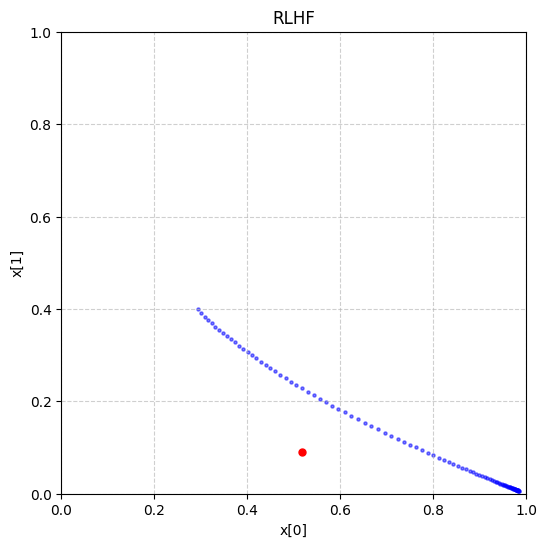

In [17]:
policy_optimizer.optimize(states=states, num_epochs=100)


In [18]:
state_0 = torch.tensor([0.0], dtype=torch.float32).to(device)
action_0 = torch.tensor([1,0,0], dtype=torch.float32).to(device)
action_1 = torch.tensor([0,0,1], dtype=torch.float32).to(device)
action_2 = torch.tensor([0,1,0], dtype=torch.float32).to(device)
print(learned_reward_model(state_0,action_0))
print(learned_reward_model(state_0,action_1))
print(learned_reward_model(state_0,action_2))

tensor([0.3088], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.1832], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.0883], device='cuda:0', grad_fn=<ViewBackward0>)


In [19]:
# output the probabilities of each action from the learned policy
test_state = torch.tensor([[0.0]], dtype=torch.float32).to(device)  

with torch.no_grad():
    action_probs = policy(test_state)
    action_probs = action_probs.cpu().numpy()[0]  

actions = [-10, 0, 10]  
for action, prob in zip(actions, action_probs):
    print(f"P(action={action}) = {prob:.3f}")

# output the probabilities of each action from the reference policy
ref_probs = ref_policy(test_state).cpu().numpy()[0]
print("\nUniform policy probabilities:")
for action, prob in zip(actions, ref_probs):
    print(f"P(action={action}) = {prob:.3f}")

P(action=-10) = 0.984
P(action=0) = 0.006
P(action=10) = 0.010

Uniform policy probabilities:
P(action=-10) = 0.333
P(action=0) = 0.333
P(action=10) = 0.333


In [20]:
# compare the learned policy with the reference policy
score = model_comparison(policy, ref_policy,feature_func)
print(f"\nRLHF model and base model comparison score: {score:.3f}")


RLHF model and base model comparison score: 0.077


/home/hanwen/policy_optimization/exp/utils/utils.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


## DPO

In [21]:
policy_dpo_1 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_dpo_2 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_dpo_3 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_dpo_4 = PolicyModel(   
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

In [22]:
dpo_optimizer_1 = DirectPreferenceOptimizer(
    policy=policy_dpo_1,
    ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point
)

dpo_optimizer_2 = DirectPreferenceOptimizer(
    policy=policy_dpo_2,
    ref_policy=ref_policy2,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point
)

dpo_optimizer_3 = DirectPreferenceOptimizer(
    policy=policy_dpo_3,
    ref_policy=ref_policy3,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point
)

dpo_optimizer_4 = DirectPreferenceOptimizer(
    policy=policy_dpo_4,
    ref_policy=ref_policy4,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point
)

2024-11-20 21:37:31,322 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 0 loss: 0.6941 grad norm: 0.0388 
2024-11-20 21:37:31,340 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 5 loss: 0.6914 grad norm: 0.0246 
2024-11-20 21:37:31,358 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 10 loss: 0.6899 grad norm: 0.0162 
2024-11-20 21:37:31,376 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 15 loss: 0.6892 grad norm: 0.0098 
2024-11-20 21:37:31,394 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 20 loss: 0.6888 grad norm: 0.0032 
2024-11-20 21:37:31,412 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 25 loss: 0.6888 grad norm: 0.0028 
2024-11-20 21:37:31,430 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 30 loss: 0.6889 grad n

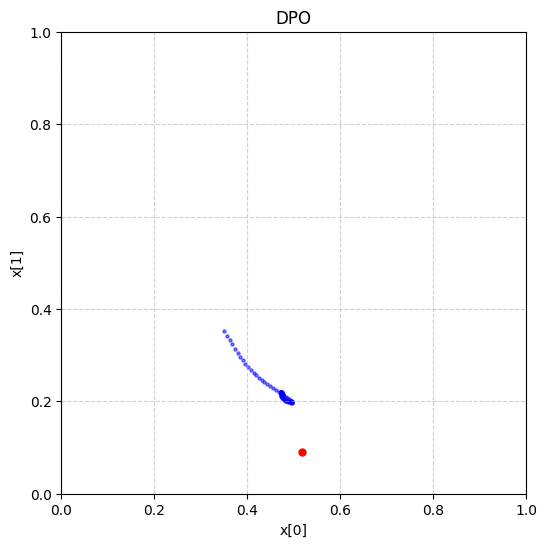

2024-11-20 21:37:31,888 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 0 loss: 0.7341 grad norm: 0.1131 
2024-11-20 21:37:31,910 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 5 loss: 0.7218 grad norm: 0.1069 
2024-11-20 21:37:31,930 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 10 loss: 0.7116 grad norm: 0.0981 
2024-11-20 21:37:31,949 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 15 loss: 0.7030 grad norm: 0.0882 
2024-11-20 21:37:31,968 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 20 loss: 0.6961 grad norm: 0.0685 
2024-11-20 21:37:31,986 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 25 loss: 0.6917 grad norm: 0.0426 
2024-11-20 21:37:32,005 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 30 loss: 0.6895 grad n

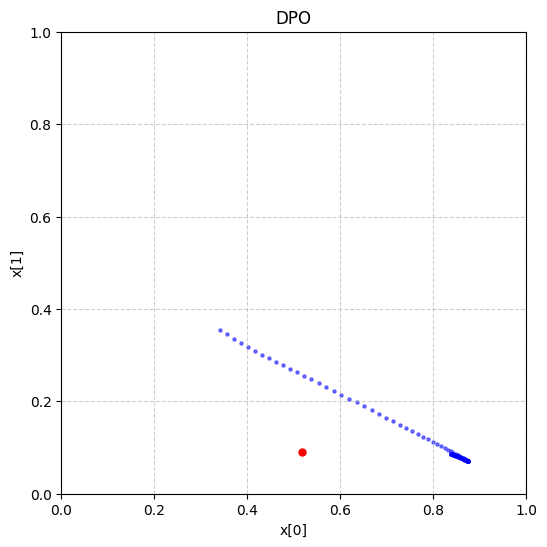

2024-11-20 21:37:32,481 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 0 loss: 0.7931 grad norm: 0.1478 
2024-11-20 21:37:32,500 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 5 loss: 0.7792 grad norm: 0.1504 
2024-11-20 21:37:32,518 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 10 loss: 0.7664 grad norm: 0.1512 
2024-11-20 21:37:32,536 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 15 loss: 0.7542 grad norm: 0.1526 
2024-11-20 21:37:32,554 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 20 loss: 0.7420 grad norm: 0.1499 
2024-11-20 21:37:32,571 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 25 loss: 0.7305 grad norm: 0.1389 
2024-11-20 21:37:32,590 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 30 loss: 0.7205 grad n

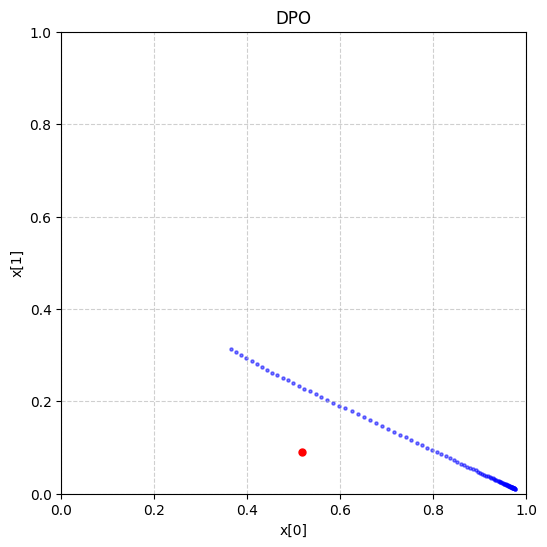

2024-11-20 21:37:33,046 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 0 loss: 0.7037 grad norm: 0.0550 
2024-11-20 21:37:33,064 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 5 loss: 0.6993 grad norm: 0.0448 
2024-11-20 21:37:33,082 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 10 loss: 0.6964 grad norm: 0.0372 
2024-11-20 21:37:33,100 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 15 loss: 0.6943 grad norm: 0.0342 
2024-11-20 21:37:33,118 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 20 loss: 0.6925 grad norm: 0.0312 
2024-11-20 21:37:33,148 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 25 loss: 0.6909 grad norm: 0.0264 
2024-11-20 21:37:33,168 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 30 loss: 0.6897 grad n

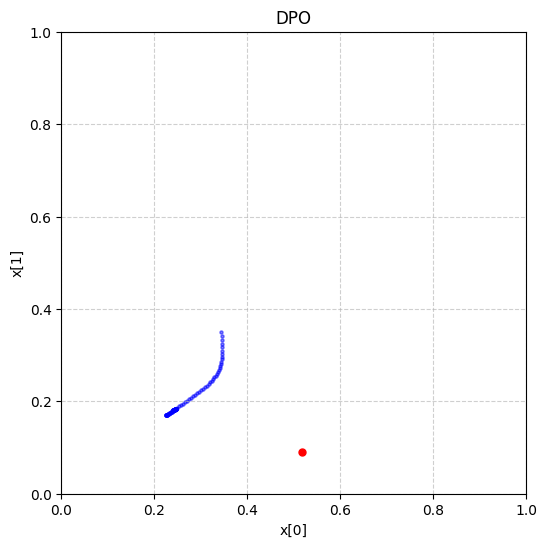

In [23]:
dpo_optimizer_1.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    num_epochs=100
) # ref_policy = [0.33,0.33,0.33]

dpo_optimizer_2.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    num_epochs=100
) # ref_policy = [0.7,0.2,0.1]

dpo_optimizer_3.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    num_epochs=100
) # ref_policy = [1.0,0.0,0.0]

dpo_optimizer_4.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    num_epochs=100
) # ref_policy = [0.1,0.3,0.6]

In [24]:
test_state = torch.zeros(1, 1, dtype=torch.float32).to(device)
with torch.no_grad():
    action_probs = policy_dpo_1(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
# compare the learned policy with the reference policy
score = model_comparison(policy_dpo_1, ref_policy,feature_func)
print(f"\nDPO model and base model comparison score: {score:.3f}")

with torch.no_grad():
    action_probs = policy_dpo_2(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score2 = model_comparison(policy_dpo_2, ref_policy2,feature_func)
print(f"\nDPO model and base model comparison score: {score2:.3f}")

with torch.no_grad():
    action_probs = policy_dpo_3(test_state)
    print("\nLearned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score3 = model_comparison(policy_dpo_3, ref_policy3,feature_func)
print(f"\nDPO model and base model comparison score: {score3:.3f}")

with torch.no_grad():
    action_probs = policy_dpo_4(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score4 = model_comparison(policy_dpo_4, ref_policy4,feature_func)
print(f"\nDPO model and base model comparison score: {score4:.3f}")


Learned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:
P(action=-10) = 0.475
P(action=0) = 0.215
P(action=10) = 0.310

DPO model and base model comparison score: 0.007

Learned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:
P(action=-10) = 0.839
P(action=0) = 0.086
P(action=10) = 0.076

DPO model and base model comparison score: 0.011

Learned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:
P(action=-10) = 0.976
P(action=0) = 0.011
P(action=10) = 0.014

DPO model and base model comparison score: 0.000

Learned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:
P(action=-10) = 0.240
P(action=0) = 0.180
P(action=10) = 0.579

DPO model and base model comparison score: 0.016


## SPPO

In [25]:
policy_sppo_1 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_sppo_2 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_sppo_3 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_sppo_4 = PolicyModel(   
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

In [26]:
chosen_probs = torch.tensor([x.chosen_probs for x in pref_dataset], dtype=torch.float32).to(device)

In [27]:
sppo_optimizer_1 = SelfPlayPreferenceOptimizer(
    policy=policy_sppo_1,
    ref_policy=ref_policy,
    learning_rate=1e-2,
    batch_size=64,
    eta=1e-3,  
    logger=logger,
    nash_point = nash_point
)

sppo_optimizer_2 = SelfPlayPreferenceOptimizer(
    policy=policy_sppo_2,
    ref_policy=ref_policy2,
    learning_rate=1e-2,
    batch_size=64,
    eta=1e-3,  
    logger=logger,
    nash_point = nash_point
)

sppo_optimizer_3 = SelfPlayPreferenceOptimizer(
    policy=policy_sppo_3,
    ref_policy=ref_policy3,
    learning_rate=1e-2,
    batch_size=64,
    eta=1e-3,  
    logger=logger,
    nash_point = nash_point
)

sppo_optimizer_4 = SelfPlayPreferenceOptimizer(
    policy=policy_sppo_4,
    ref_policy=ref_policy4,
    learning_rate=1e-2,
    batch_size=64,
    eta=1e-3,  
    logger=logger,
    nash_point = nash_point
)

2024-11-20 21:37:34,151 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 0 loss: 0.0059 grad norm: 0.0999 


2024-11-20 21:37:34,178 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 5 loss: 0.0002 grad norm: 0.0165 
2024-11-20 21:37:34,204 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 10 loss: 0.0007 grad norm: 0.0239 
2024-11-20 21:37:34,232 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 15 loss: 0.0005 grad norm: 0.0236 
2024-11-20 21:37:34,260 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 20 loss: 0.0000 grad norm: 0.0041 
2024-11-20 21:37:34,287 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 25 loss: 0.0001 grad norm: 0.0096 
2024-11-20 21:37:34,315 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 30 loss: 0.0000 grad norm: 0.0057 
2024-11-20 21:37:34,345 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 35 loss: 0.0000 grad 

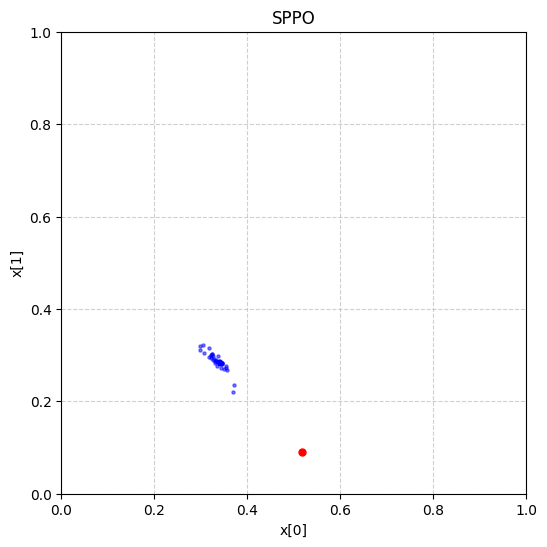

2024-11-20 21:37:36,185 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 0 loss: 0.1141 grad norm: 0.3629 
2024-11-20 21:37:36,211 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 5 loss: 0.0027 grad norm: 0.0750 
2024-11-20 21:37:36,242 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 10 loss: 0.0013 grad norm: 0.0357 
2024-11-20 21:37:36,268 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 15 loss: 0.0011 grad norm: 0.0336 
2024-11-20 21:37:36,292 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 20 loss: 0.0001 grad norm: 0.0082 
2024-11-20 21:37:36,316 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 25 loss: 0.0004 grad norm: 0.0233 
2024-11-20 21:37:36,343 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 30 loss: 0.0000 grad n

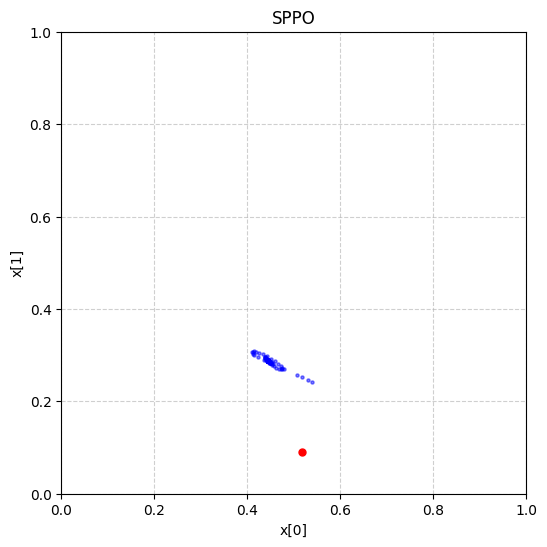

2024-11-20 21:37:37,745 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 0 loss: 0.4042 grad norm: 0.6802 
2024-11-20 21:37:37,778 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 5 loss: 0.0096 grad norm: 0.1519 
2024-11-20 21:37:37,803 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 10 loss: 0.0005 grad norm: 0.0254 
2024-11-20 21:37:37,827 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 15 loss: 0.0026 grad norm: 0.0513 
2024-11-20 21:37:37,851 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 20 loss: 0.0006 grad norm: 0.0276 
2024-11-20 21:37:37,877 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 25 loss: 0.0002 grad norm: 0.0178 
2024-11-20 21:37:37,903 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 30 loss: 0.0005 grad n

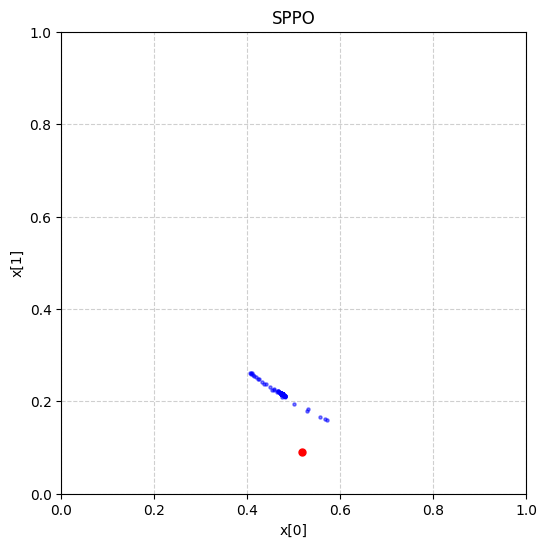

2024-11-20 21:37:39,603 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 0 loss: 0.0827 grad norm: 0.3577 
2024-11-20 21:37:39,634 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 5 loss: 0.0026 grad norm: 0.0493 
2024-11-20 21:37:39,660 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 10 loss: 0.0003 grad norm: 0.0178 
2024-11-20 21:37:39,683 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 15 loss: 0.0008 grad norm: 0.0298 
2024-11-20 21:37:39,708 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 20 loss: 0.0001 grad norm: 0.0129 
2024-11-20 21:37:39,733 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 25 loss: 0.0002 grad norm: 0.0126 
2024-11-20 21:37:39,760 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 30 loss: 0.0000 grad n

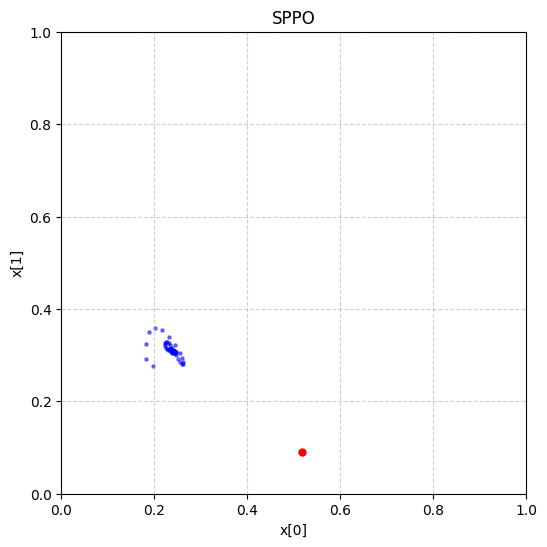

In [28]:
sppo_optimizer_1.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    chosen_probs=chosen_probs,
    num_epochs=300
)

sppo_optimizer_2.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    chosen_probs=chosen_probs,
    num_epochs=300
)

sppo_optimizer_3.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    chosen_probs=chosen_probs,
    num_epochs=300
)

sppo_optimizer_4.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    chosen_probs=chosen_probs,
    num_epochs=300
)

In [29]:
test_state = torch.zeros(1, 1, dtype=torch.float32).to(device)
with torch.no_grad():
    action_probs = policy_sppo_1(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
score = model_comparison(policy_sppo_1, ref_policy,feature_func)
print(f"\nSPPO model and base model comparison score: {score:.3f}")


with torch.no_grad():
    action_probs = policy_sppo_2(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score2 = model_comparison(policy_sppo_2, ref_policy2,feature_func)
print(f"\nSPPO model and base model comparison score: {score2:.3f}")

with torch.no_grad():
    action_probs = policy_sppo_3(test_state)
    print("\nLearned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score3 = model_comparison(policy_sppo_3, ref_policy3,feature_func)
print(f"\nSPPO model and base model comparison score: {score3:.3f}")

with torch.no_grad():
    action_probs = policy_sppo_4(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score4 = model_comparison(policy_sppo_4, ref_policy4,feature_func)
print(f"\nSPPO model and base model comparison score: {score4:.3f}")


Learned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:
P(action=-10) = 0.341
P(action=0) = 0.283
P(action=10) = 0.376

SPPO model and base model comparison score: 0.000

Learned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:
P(action=-10) = 0.444
P(action=0) = 0.288
P(action=10) = 0.268

SPPO model and base model comparison score: -0.037

Learned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:
P(action=-10) = 0.474
P(action=0) = 0.217
P(action=10) = 0.309

SPPO model and base model comparison score: -0.084

Learned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:
P(action=-10) = 0.240
P(action=0) = 0.309
P(action=10) = 0.451

SPPO model and base model comparison score: 0.006


## SPPO Closed-form solution

In [30]:
sppo_closed_form_1 = SPPOClosedForm(
    ref_policy=ref_policy,
    eta=1e-2,
    batch_size=64,
    logger=logger,
    device=device,
    nash_point=nash_point
)

sppo_closed_form_2 = SPPOClosedForm(   
    ref_policy=ref_policy2,
    eta=1e-2,
    batch_size=64,
    logger=logger,
    device=device,
    nash_point=nash_point
)

sppo_closed_form_3 = SPPOClosedForm(
    ref_policy=ref_policy3,
    eta=1e-2,
    batch_size=64,
    logger=logger,
    device=device,
    nash_point=nash_point
)

sppo_closed_form_4 = SPPOClosedForm(
    ref_policy=ref_policy4,
    eta=1e-2,
    batch_size=64,
    logger=logger,
    device=device,
    nash_point=nash_point
)

2024-11-20 21:37:41,778 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 0: ref_distribution = tensor([0.3333, 0.3333, 0.3333], device='cuda:0'), new_distribution = tensor([0.3348, 0.3334, 0.3318], device='cuda:0')
2024-11-20 21:37:41,784 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 1: ref_distribution = tensor([0.3348, 0.3334, 0.3318], device='cuda:0'), new_distribution = tensor([0.3355, 0.3327, 0.3318], device='cuda:0')
2024-11-20 21:37:41,789 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 2: ref_distribution = tensor([0.3355, 0.3327, 0.3318], device='cuda:0'), new_distribution = tensor([0.3372, 0.3323, 0.3305], device='cuda:0')
2024-11-20 21:37:41,794 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 3: ref_distribution = tensor([0.3372, 0.3323, 0.3305], device='cuda:0'), new_distribution = tensor([0.3384, 0.3328, 0.3287], device='cuda:0')


2024-11-20 21:37:41,799 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 4: ref_distribution = tensor([0.3384, 0.3328, 0.3287], device='cuda:0'), new_distribution = tensor([0.3384, 0.3343, 0.3273], device='cuda:0')
2024-11-20 21:37:41,804 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 5: ref_distribution = tensor([0.3384, 0.3343, 0.3273], device='cuda:0'), new_distribution = tensor([0.3394, 0.3346, 0.3260], device='cuda:0')
2024-11-20 21:37:41,809 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 6: ref_distribution = tensor([0.3394, 0.3346, 0.3260], device='cuda:0'), new_distribution = tensor([0.3397, 0.3356, 0.3248], device='cuda:0')
2024-11-20 21:37:41,815 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 7: ref_distribution = tensor([0.3397, 0.3356, 0.3248], device='cuda:0'), new_distribution = tensor([0.3419, 0.3356, 0.3225], device='cuda:0')
2024-11-20 21:37

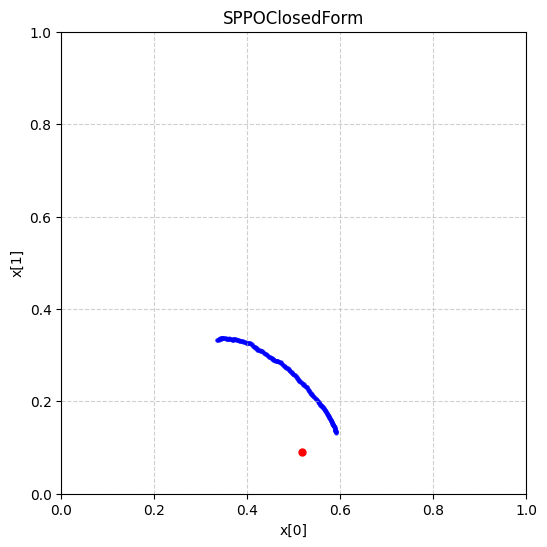

2024-11-20 21:37:43,478 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 0: ref_distribution = tensor([0.7000, 0.2000, 0.1000], device='cuda:0'), new_distribution = tensor([0.7014, 0.1985, 0.1001], device='cuda:0')
2024-11-20 21:37:43,482 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 1: ref_distribution = tensor([0.7014, 0.1985, 0.1001], device='cuda:0'), new_distribution = tensor([0.7026, 0.1973, 0.1001], device='cuda:0')
2024-11-20 21:37:43,486 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 2: ref_distribution = tensor([0.7026, 0.1973, 0.1001], device='cuda:0'), new_distribution = tensor([0.7042, 0.1957, 0.1000], device='cuda:0')
2024-11-20 21:37:43,490 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 3: ref_distribution = tensor([0.7042, 0.1957, 0.1000], device='cuda:0'), new_distribution = tensor([0.7060, 0.1936, 0.1004], device='cuda:0')
2024-11-20 21:37

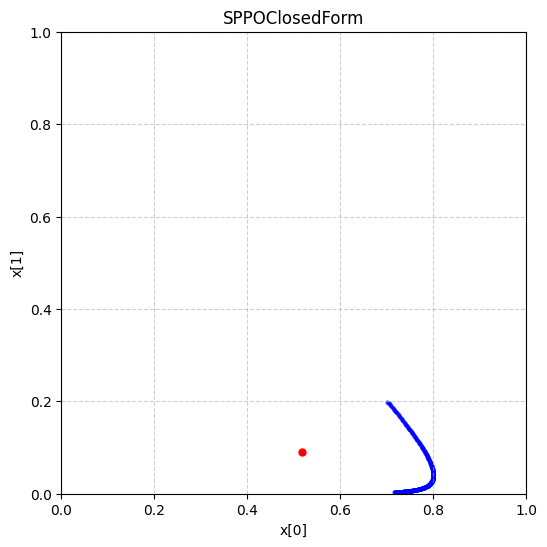

2024-11-20 21:37:45,247 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 0: ref_distribution = tensor([1., 0., 0.], device='cuda:0'), new_distribution = tensor([1., 0., 0.], device='cuda:0')
2024-11-20 21:37:45,252 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 1: ref_distribution = tensor([1., 0., 0.], device='cuda:0'), new_distribution = tensor([1., 0., 0.], device='cuda:0')
2024-11-20 21:37:45,257 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 2: ref_distribution = tensor([1., 0., 0.], device='cuda:0'), new_distribution = tensor([1., 0., 0.], device='cuda:0')
2024-11-20 21:37:45,262 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 3: ref_distribution = tensor([1., 0., 0.], device='cuda:0'), new_distribution = tensor([1., 0., 0.], device='cuda:0')
2024-11-20 21:37:45,266 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 4: ref_d

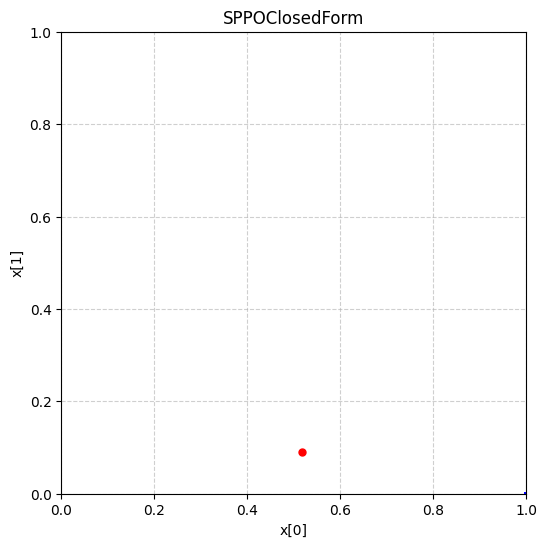

2024-11-20 21:37:46,659 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 0: ref_distribution = tensor([0.1000, 0.3000, 0.6000], device='cuda:0'), new_distribution = tensor([0.0997, 0.3028, 0.5975], device='cuda:0')
2024-11-20 21:37:46,665 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 1: ref_distribution = tensor([0.0997, 0.3028, 0.5975], device='cuda:0'), new_distribution = tensor([0.0999, 0.3058, 0.5943], device='cuda:0')
2024-11-20 21:37:46,670 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 2: ref_distribution = tensor([0.0999, 0.3058, 0.5943], device='cuda:0'), new_distribution = tensor([0.0999, 0.3091, 0.5910], device='cuda:0')
2024-11-20 21:37:46,675 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 3: ref_distribution = tensor([0.0999, 0.3091, 0.5910], device='cuda:0'), new_distribution = tensor([0.1001, 0.3121, 0.5878], device='cuda:0')
2024-11-20 21:37

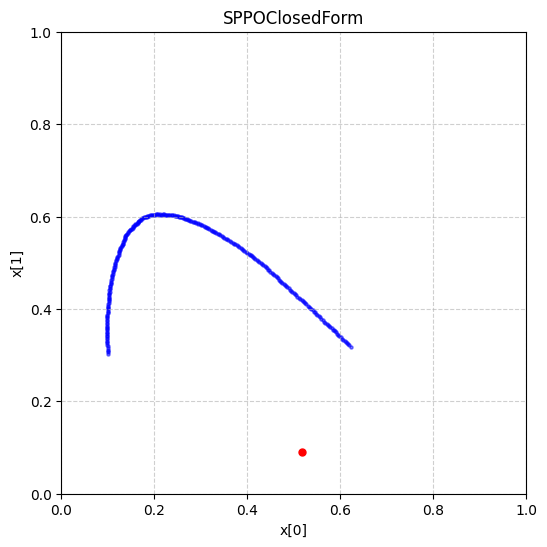

In [31]:
sppo_distribution_1 = sppo_closed_form_1.optimize(
    p_list=p_list,
    num_iters=300
)   

sppo_distribution2 = sppo_closed_form_2.optimize(
    p_list=p_list,
    num_iters=300
)

sppo_distribution3 = sppo_closed_form_3.optimize(
    p_list=p_list,
    num_iters=300
)

sppo_distribution4 = sppo_closed_form_4.optimize(
    p_list=p_list,
    num_iters=300
)

### Summary

In [32]:
test_state = torch.zeros(1, 1, dtype=torch.float32).to(device)
with torch.no_grad():
    
    print("\n ##### Learned policy probabilities of RLHF: #####")
    action_probs = policy(test_state)
    print("\nLearned policy probabilities(RLHF):")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score = model_comparison(policy, ref_policy,feature_func)
    print(f"\nRLHF model and base model comparison score: {score:.3f}")


 ##### Learned policy probabilities of RLHF: #####

Learned policy probabilities(RLHF):
P(action=-10) = 0.984
P(action=0) = 0.006
P(action=10) = 0.010

RLHF model and base model comparison score: 0.102


In [33]:
print("\n ##### Learned policy probabilities of DPO: #####")
with torch.no_grad():
    
    action_probs_dpo1 = policy_dpo_1(test_state)
    print("\nLearned policy probabilities(DPO), ref_model = [0.33,0.33,0.33]:")
    for action, prob in zip(actions, action_probs_dpo1[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
    score_dpo1 = model_comparison(policy_dpo_1, ref_policy,feature_func)
    print(f"\nDPO model and base model comparison score: {score_dpo1:.3f}")
    
    
    action_probs_dpo2 = policy_dpo_2(test_state)
    print("\nLearned policy probabilities(DPO), ref_model = [0.7,0.2,0.1]:")
    for action, prob in zip(actions, action_probs_dpo2[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
    score_dpo2 = model_comparison(policy_dpo_2, ref_policy2,feature_func)
    print(f"\nDPO model and base model comparison score: {score_dpo2:.3f}")
    
    
    action_probs_dpo3 = policy_dpo_3(test_state)
    print("\nLearned policy probabilities(DPO), ref_model = [1.0,0.0,0.0]:")
    for action, prob in zip(actions, action_probs_dpo3[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
    score_dpo3 = model_comparison(policy_dpo_3, ref_policy3,feature_func)
    print(f"\nDPO model and base model comparison score: {score_dpo3:.3f}")
    
    
    action_probs_dpo4 = policy_dpo_4(test_state)
    print("\nLearned policy probabilities(DPO), ref_model = [0.1,0.3,0.6]:")
    for action, prob in zip(actions, action_probs_dpo4[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_dpo4 = model_comparison(policy_dpo_4, ref_policy4,feature_func)
    print(f"\nDPO model and base model comparison score: {score_dpo4:.3f}")


 ##### Learned policy probabilities of DPO: #####

Learned policy probabilities(DPO), ref_model = [0.33,0.33,0.33]:
P(action=-10) = 0.475
P(action=0) = 0.215
P(action=10) = 0.310

DPO model and base model comparison score: 0.003

Learned policy probabilities(DPO), ref_model = [0.7,0.2,0.1]:
P(action=-10) = 0.839
P(action=0) = 0.086
P(action=10) = 0.076

DPO model and base model comparison score: 0.016

Learned policy probabilities(DPO), ref_model = [1.0,0.0,0.0]:
P(action=-10) = 0.976
P(action=0) = 0.011
P(action=10) = 0.014

DPO model and base model comparison score: -0.005

Learned policy probabilities(DPO), ref_model = [0.1,0.3,0.6]:
P(action=-10) = 0.240
P(action=0) = 0.180
P(action=10) = 0.579

DPO model and base model comparison score: 0.024


In [34]:
print("\n ##### Learned policy probabilities of SPPO: #####")
with torch.no_grad():
    action_probs_sppo1 = policy_sppo_1(test_state)
    print("\nLearned policy probabilities(SPPO), ref_model = [0.33,0.33,0.33]:")
    for action, prob in zip(actions, action_probs_sppo1[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo1 = model_comparison(policy_sppo_1, ref_policy,feature_func)
    print(f"\nSPPO model and base model comparison score: {score_sppo1:.3f}")
    
    
    action_probs_sppo2 = policy_sppo_2(test_state)
    print("\nLearned policy probabilities(SPPO), ref_model = [0.7,0.2,0.1]:")
    for action, prob in zip(actions, action_probs_sppo2[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo2 = model_comparison(policy_sppo_2, ref_policy2,feature_func)
    print(f"\nSPPO model and base model comparison score: {score_sppo2:.3f}")
    
    
    action_probs_sppo3 = policy_sppo_3(test_state)
    print("\nLearned policy probabilities(SPPO), ref_model = [1.0,0.0,0.0]:")
    for action, prob in zip(actions, action_probs_sppo3[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo3 = model_comparison(policy_sppo_3, ref_policy3,feature_func)
    print(f"\nSPPO model and base model comparison score: {score_sppo3:.3f}")
    
    
    action_probs_sppo4 = policy_sppo_4(test_state)
    print("\nLearned policy probabilities(SPPO), ref_model = [0.1,0.3,0.6]:")
    for action, prob in zip(actions, action_probs_sppo4[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo4 = model_comparison(policy_sppo_4, ref_policy4,feature_func)
    print(f"\nSPPO model and base model comparison score: {score_sppo4:.3f}")


 ##### Learned policy probabilities of SPPO: #####

Learned policy probabilities(SPPO), ref_model = [0.33,0.33,0.33]:
P(action=-10) = 0.341
P(action=0) = 0.283
P(action=10) = 0.376



SPPO model and base model comparison score: -0.004

Learned policy probabilities(SPPO), ref_model = [0.7,0.2,0.1]:
P(action=-10) = 0.444
P(action=0) = 0.288
P(action=10) = 0.268

SPPO model and base model comparison score: -0.036

Learned policy probabilities(SPPO), ref_model = [1.0,0.0,0.0]:
P(action=-10) = 0.474
P(action=0) = 0.217
P(action=10) = 0.309

SPPO model and base model comparison score: -0.088

Learned policy probabilities(SPPO), ref_model = [0.1,0.3,0.6]:
P(action=-10) = 0.240
P(action=0) = 0.309
P(action=10) = 0.451

SPPO model and base model comparison score: 0.028


In [35]:
print("\n ##### Learned policy probabilities of SPPO-ClosedForm: #####")
with torch.no_grad():
    action_probs_sppo1 = sppo_distribution_1
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [0.33,0.33,0.33]:")
    for action, prob in zip(actions, action_probs_sppo1.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo1 = distribution_comparison(sppo_distribution_1, ref_policy,feature_func)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo1:.3f}")
    
    
    action_probs_sppo2 = sppo_distribution2
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [0.7,0.2,0.1]:")
    for action, prob in zip(actions, action_probs_sppo2.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo2 = distribution_comparison(sppo_distribution2, ref_policy2,feature_func)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo2:.3f}")
    
    
    action_probs_sppo3 = sppo_distribution3
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [1.0,0.0,0.0]:")
    for action, prob in zip(actions, action_probs_sppo3.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo3 = distribution_comparison(sppo_distribution3, ref_policy3,feature_func)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo3:.3f}")
    
    
    action_probs_sppo4 = sppo_distribution4
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [0.1,0.3,0.6]:")
    for action, prob in zip(actions, action_probs_sppo4.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo4 = distribution_comparison(sppo_distribution4, ref_policy4,feature_func)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo4:.3f}")
        


 ##### Learned policy probabilities of SPPO-ClosedForm: #####

Learned policy probabilities(SPPO-ClosedForm), ref_model = [0.33,0.33,0.33]:
P(action=-10) = 0.591
P(action=0) = 0.132
P(action=10) = 0.277



SPPO-ClosedForm model and base model comparison score: 0.032

Learned policy probabilities(SPPO-ClosedForm), ref_model = [0.7,0.2,0.1]:
P(action=-10) = 0.716
P(action=0) = 0.003
P(action=10) = 0.280

SPPO-ClosedForm model and base model comparison score: 0.006

Learned policy probabilities(SPPO-ClosedForm), ref_model = [1.0,0.0,0.0]:
P(action=-10) = 1.000
P(action=0) = 0.000
P(action=10) = 0.000

SPPO-ClosedForm model and base model comparison score: 0.000

Learned policy probabilities(SPPO-ClosedForm), ref_model = [0.1,0.3,0.6]:
P(action=-10) = 0.622
P(action=0) = 0.318
P(action=10) = 0.060

SPPO-ClosedForm model and base model comparison score: 0.073
